## MNIST Digits 4<->9 Generation using Cycle GAN


*   we’ll be implementing MNIST digits conversion from 4 to 9 and vice versa



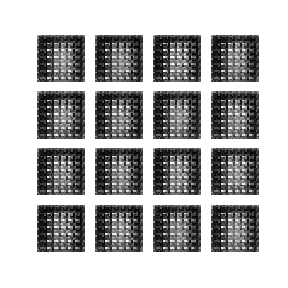

## Pipeline
Steps Involved


1. Importing Libraries
2. Data Loading and Visualization
3. Data Preprocessing
4. Model Building
5. Model Training
6. Generating a GIF of Generated Images



### Importing Libraries


Important Libraries and their versions
*   numpy - 1.19.2
*   tensorflow - 2.4.1
*   matplotlib - 3.3.2
*   skimage - 0.17.2

In [1]:
# Using Tensorflow-2.4.x
import tensorflow as tf
try:
    tf_gpus = tf.config.list_physical_devices('GPU')
    for gpu in tf_gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass 

In [2]:
#Importing necessary Libraries.
# import tensorflow as tf
import matplotlib.pyplot as plt
import glob # to find certain directories
import imageio
from IPython import display
from skimage.transform import resize
import numpy as np
import os # to access the folders and files
from keras.utils.vis_utils import plot_model

### Data Loading and Visualization
1. Data Loading
2. Data Visualization

#### Load the MNIST Data

In [3]:
# Loading the MNIST Dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

#### Visualize a sample image

### Data Preprocessing


1.   Normalization of Images
2.   Resize Images
1.   Reshape Images
2.   Shuffle Data





#### Declare Buffer Size, Batch Size and Dimensions of Noise


In [4]:
# BUFFER_SIZE = 60000
BATCH_SIZE = 128
EPOCHS = 100
# NOISE_DIM = 100

#### Normalization of Images between [-1, 1]
Pixel Normalization with zero center

In [5]:
img4 = train_images[train_labels==4]
img4 = (img4/127.5)-1.0 # Normalize the images to [-1.0, 1.0]
img4.shape

(5842, 28, 28)

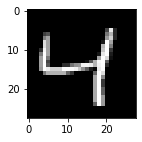

In [6]:
plt.figure(figsize=(2,2))
plt.imshow(img4[0],cmap='gray')
plt.show()

In [7]:
img9 = train_images[train_labels==9]
img9 = (img9/127.5)-1.0 # Normalize the images to [-1.0, 1.0]
img9.shape

(5949, 28, 28)

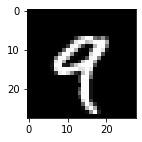

In [8]:
plt.figure(figsize=(2,2))
plt.imshow(img9[0],cmap='gray')
plt.show()

#### Resize Images to size (32, 32)


In [9]:
digit4_data = np.zeros((img4.shape[0], 32, 32))
for index, img in enumerate(img4):
    digit4_data[index, :, :] = resize(img, (32, 32))
digit4_data.shape

(5842, 32, 32)

In [10]:
digit9_data = np.zeros((img9.shape[0], 32, 32))
for index, img in enumerate(img9):
    digit9_data[index, :, :] = resize(img, (32, 32))
digit9_data.shape

(5949, 32, 32)

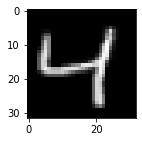

(32, 32)


In [11]:
plt.figure(figsize=(2, 2))
plt.imshow(digit4_data[0], cmap='gray')
# plt.axis('off')
plt.show()
print(digit4_data[0].shape)

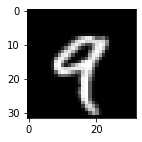

(32, 32)


In [12]:
plt.figure(figsize=(2, 2))
plt.imshow(digit9_data[0], cmap='gray')
# plt.axis('off')
plt.show()
print(digit9_data[0].shape)

#### Reshape Image to add channel dimension

In [13]:
digit4_data = digit4_data.reshape(digit4_data.shape[0], 32, 32, 1).astype('float32')
digit9_data = digit9_data.reshape(digit9_data.shape[0], 32, 32, 1).astype('float32')

#### Shuffle the data and store in Batches
shuffle - Randomly shuffles the elements of this dataset.

batch - Combines consecutive elements of this dataset into batches.

In [14]:
# Batch and shuffle the data
digit4_data = tf.data.Dataset.from_tensor_slices(digit4_data).shuffle(img4.shape[0], seed=42).batch(BATCH_SIZE)
digit9_data = tf.data.Dataset.from_tensor_slices(digit9_data).shuffle(img9.shape[0], seed=42).batch(BATCH_SIZE)

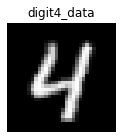

In [15]:
sample_digit4_data = next(iter(digit4_data))
plt.figure(figsize=(2, 2))
plt.imshow(sample_digit4_data[0].numpy()[:, :, 0], cmap='gray')
plt.title("digit4_data")
plt.axis('off')
plt.show()

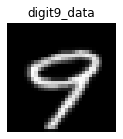

In [16]:
sample_digit9_data  = next(iter(digit9_data))
plt.figure(figsize=(2, 2))
plt.imshow(sample_digit9_data[0].numpy()[:, :, 0], cmap='gray')
plt.title("digit9_data")
plt.axis('off')
plt.show()

### Model Building


1.   instance normalization
2.   Downsampling, Upsampling and Unet
3.   Generator Building using Unet
4.   Discriminator Model Building



#### Instance Normalization
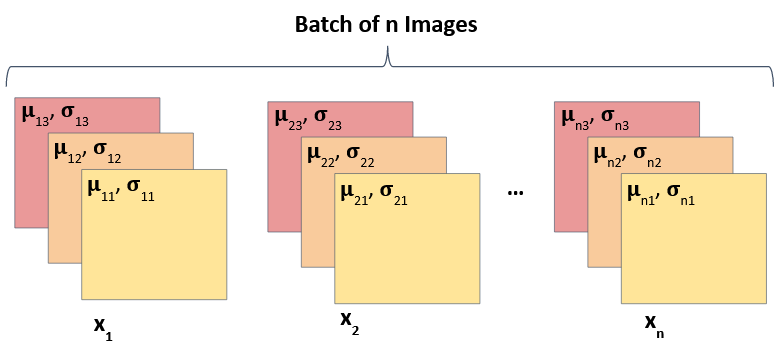

#### Generator Model Building using Transposed Convolutional Layers

In [17]:
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # Calling parent's init
        super(InstanceNormalization,self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)
    
    def call(self,X):
        # Compute the Mean, Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(X, axes=[1,2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (X - mean) * inv
        return self.scale * normalized + self.offset        

#### Dowmsampling
Downsampling is performed using the Convolution, leading to reduce in dimensions

In [18]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer,use_bias=False))
    
    # Add Normalization Layer
    if apply_norm:
        result.add(InstanceNormalization())
    # Add Leaky Relu Activation
    result.add(tf.keras.layers.LeakyReLU())
    return result

#### Upsampling
Upsampling is a result of Transposed Convolution, where dimension of image are increased and channels are decreased.

In [19]:
def upsample(filters, size, apply_dropout=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer,use_bias=False))
    
    # Add Normalization Layer
    result.add(InstanceNormalization())
        
    # Conditionally add Dropout
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    # Add Leaky Relu Activation
    result.add(tf.keras.layers.LeakyReLU())
    return result

#### Unet

In [20]:
def unet_generator( ):
    down_stack = [
        downsample(64, 4, False), #(bs, 16, 16, 64)
        downsample(128, 4), #(bs, 8, 8, 128)
        downsample(128, 4), #(bs, 4, 4, 128)
        downsample(128, 4), #(bs, 2, 2, 128)
        downsample(128, 4), #(bs, 1, 1, 128)
    ]
    up_stack = [
        upsample(128, 4, True), # (bs, 2, 2, 256)
        upsample(128, 4, True), # (bs, 4, 4, 256)
        upsample(128, 4), # (bs, 8, 8, 256)
        upsample(64, 4), # (bs, 16, 16, 256)        
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides = 2, padding = 'same',kernel_initializer=initializer, activation= 'tanh' )
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.Input(shape = [32, 32, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

#### Generator
Generator is a Unet Network here since We want to translate One type of Image (digit4) into Another type of image (digit 9)

In [21]:
generator_g = unet_generator()
generator_f = unet_generator()

 Let's also visualize one of our Generator models since Both our Generators have same architechture.
 
Notice  How the dimension reduces first but then increases.

In [22]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 16, 16, 64)   1024        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 8, 8, 128)    131328      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4, 4, 128)    262400      sequential_1[0][0]               
______________________________________________________________________________________________

#### Discriminator 
Discriminator is a traditional CNN, Which we use to classify the images. It only uses Downsampling hence.
Both Discriminators have same architecture.

In [23]:
def discriminator():
    initializer = tf.random_normal_initializer(0.,0.02)
    inp = tf.keras.layers.Input(shape=[32, 32, 1], name= 'input_image')
    x = inp
    down1 = downsample(64, 4, False)(x) # (bs, 16, 16, 64)
    down2 = downsample(128, 4)(down1) # (bs, 8, 8, 128)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2) # (bs, 10, 10, 128)
    conv = tf.keras.layers.Conv2D(256, 4, strides=1, kernel_initializer= initializer, use_bias=False)(zero_pad1) # (bs, 7, 7, 128)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 9, 9, 128)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer= initializer, use_bias=False)(zero_pad2) # (bs, 7, 7, 128)
    return tf.keras.Model(inputs=inp, outputs=last)


In [24]:
discriminator_x = discriminator()
discriminator_y = discriminator()

In [25]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 32, 32, 1)]       0         
_________________________________________________________________
sequential_18 (Sequential)   (None, 16, 16, 64)        1024      
_________________________________________________________________
sequential_19 (Sequential)   (None, 8, 8, 128)         131328    
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 256)         524288    
_________________________________________________________________
instance_normalization_17 (I (None, 7, 7, 256)         512       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 7, 7, 256)         0   

#### Model Training
1. Declare Loss type
2. Calculate Discriminator Loss
3. Calculate Generator Loss
4. Cycle Loss
5. Identity Loss
6. Optimizer
7. Checkpoint Initialisation
8. Training Flow

Check output of Untrained Generator models which should be a random noise

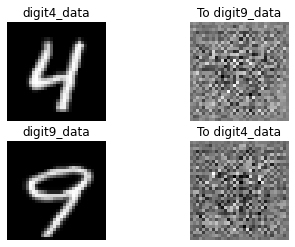

In [26]:
to_digit9_data = generator_g(sample_digit9_data)
to_digit4_data = generator_g(sample_digit4_data)

imgs = [sample_digit4_data, to_digit9_data, sample_digit9_data, to_digit4_data]
title = ['digit4_data', 'To digit9_data', 'digit9_data', 'To digit4_data']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0].numpy()[:, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

#### Declare Loss as Binary Cross Entropy
Since out Discriminator is a classifier

In [27]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator Loss
It consists of two types of losses
1. Loss on Real Data
2. Loss on Fake Data

In [28]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # mean of losses


#### Generator Loss
It has only one type of loss - Discriminator loss on Generator Data

In [29]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated),generated)

#### Cycle Loss
When we use both of Generators sequentially on input image, we get cycle image and L1 
Loss between these two is called Cycle Loss

In [30]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss1

#### Identity Loss
when we provide input to Generator such that no translation is needed because the image is already transformed.
Here we take L1 loss between input and output image.

In [31]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image, same_image))
    return 0.5 * loss

#### Optimizer
We use Adam Optimizer to update weights which is good optimizer to achieve quick learning.

In [32]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#### Checkpoint Initialization
Initialize the Checkpoints to save the models

In [33]:
# Directory to save checkpoints
checkpoint_dir = './training_checkpoints/CycleGAN/'
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer = discriminator_x_optimizer,
                           discriminator_y_optimizer = discriminator_y_optimizer,)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

#### Function to show images output by Generators while training

In [34]:
def generated_images(model1, test_imput1, model2, test_imput2):
    prediction1 = model1(test_imput1)
    prediction2 = model2(test_imput2)
    plt.figure(figsize=(4,4))
    display_list = [test_imput1[0], prediction1[0], test_imput2[0], prediction2[0]]
    title = ['Input image', 'Predicted Image', 'Input Image', 'Predicted Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')
    
    plt.savefig('./generated_images/CycleGAN/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

#### Training Flow


In [35]:
# @tf.function
def train_step(real_x, real_y):
	# Persistance is set to  true because the tape is used more than
	# once to calculate the gradients
	with tf.GradientTape(persistent=True) as tape:
		# Generate Fake Y and Cycled X
		fake_y = generator_g(real_x, training=True)
		cycled_x = generator_f(fake_y, training=True)

		# Generate Fake X and Cycled Y
		fake_x = generator_f(real_y, training=True)
		cycled_y = generator_g(fake_x, training=True)

		# Generate Fake Images through G and F for Identity Loss.
		same_x = generator_f(real_x, training=True)
		same_y = generator_g(real_y, training=True)

		# Calculate Discriminator prediction using DX and DY on real and fake data for loss calculation.
		disc_real_x = discriminator_x(real_x, training=True)
		disc_real_y = discriminator_y(real_y, training=True)

		disc_fake_x = discriminator_x(fake_x, training=True)
		disc_fake_y = discriminator_y(fake_y, training=True)

		# Calculate Generator Loss on Discriminator.
		gen_g_loss = generator_loss(disc_fake_y)
		gen_f_loss = generator_loss(disc_fake_x)

		# Calculate Cycled Loss on Cycled Images from step 1 and 2.
		total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

		# Calculate Total Generator Loss →  Disc Loss + Cycled Loss + Identity Loss.
		total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
		total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

		# Calculate Discriminator Loss on both Fake and Real Images for Disc X and Y for Disc Training.
		disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
		disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

	# Calculate the Gradients for generator and discriminator
	generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
	generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

	discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
	discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

	# Apply the gradients to the optimizer
	generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
	generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

	discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
	discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

#### Train the CycleGAN Model several Epochs
Loop training function for number of epochs and also show the output at each step.
Note how Generators are getting better at producing realistic images epoch by epoch

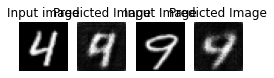

Saving checkpoint for epoch 1 at ./training_checkpoints/CycleGAN/ckpt-1


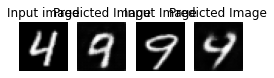

Saving checkpoint for epoch 2 at ./training_checkpoints/CycleGAN/ckpt-2


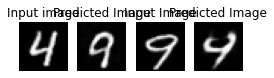

Saving checkpoint for epoch 3 at ./training_checkpoints/CycleGAN/ckpt-3


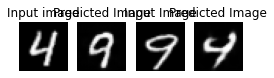

Saving checkpoint for epoch 4 at ./training_checkpoints/CycleGAN/ckpt-4


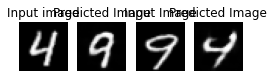

Saving checkpoint for epoch 5 at ./training_checkpoints/CycleGAN/ckpt-5


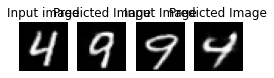

Saving checkpoint for epoch 6 at ./training_checkpoints/CycleGAN/ckpt-6


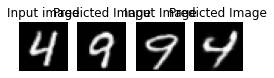

Saving checkpoint for epoch 7 at ./training_checkpoints/CycleGAN/ckpt-7


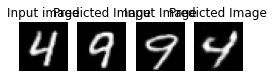

Saving checkpoint for epoch 8 at ./training_checkpoints/CycleGAN/ckpt-8


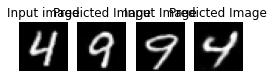

Saving checkpoint for epoch 9 at ./training_checkpoints/CycleGAN/ckpt-9


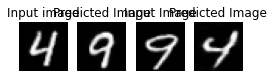

Saving checkpoint for epoch 10 at ./training_checkpoints/CycleGAN/ckpt-10


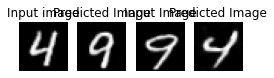

Saving checkpoint for epoch 11 at ./training_checkpoints/CycleGAN/ckpt-11


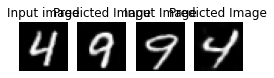

Saving checkpoint for epoch 12 at ./training_checkpoints/CycleGAN/ckpt-12


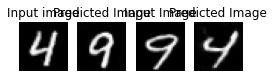

Saving checkpoint for epoch 13 at ./training_checkpoints/CycleGAN/ckpt-13


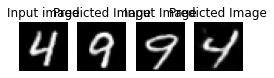

Saving checkpoint for epoch 14 at ./training_checkpoints/CycleGAN/ckpt-14


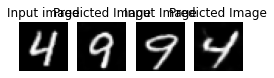

Saving checkpoint for epoch 15 at ./training_checkpoints/CycleGAN/ckpt-15


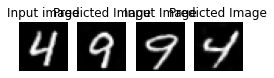

Saving checkpoint for epoch 16 at ./training_checkpoints/CycleGAN/ckpt-16


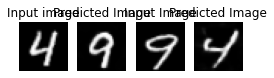

Saving checkpoint for epoch 17 at ./training_checkpoints/CycleGAN/ckpt-17


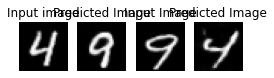

Saving checkpoint for epoch 18 at ./training_checkpoints/CycleGAN/ckpt-18


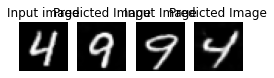

Saving checkpoint for epoch 19 at ./training_checkpoints/CycleGAN/ckpt-19


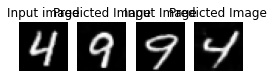

Saving checkpoint for epoch 20 at ./training_checkpoints/CycleGAN/ckpt-20


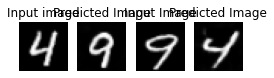

Saving checkpoint for epoch 21 at ./training_checkpoints/CycleGAN/ckpt-21


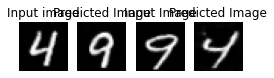

Saving checkpoint for epoch 22 at ./training_checkpoints/CycleGAN/ckpt-22


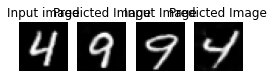

Saving checkpoint for epoch 23 at ./training_checkpoints/CycleGAN/ckpt-23


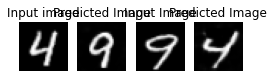

Saving checkpoint for epoch 24 at ./training_checkpoints/CycleGAN/ckpt-24


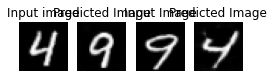

Saving checkpoint for epoch 25 at ./training_checkpoints/CycleGAN/ckpt-25


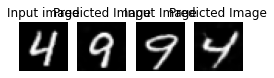

Saving checkpoint for epoch 26 at ./training_checkpoints/CycleGAN/ckpt-26


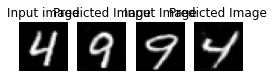

Saving checkpoint for epoch 27 at ./training_checkpoints/CycleGAN/ckpt-27


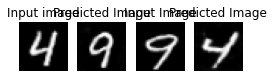

Saving checkpoint for epoch 28 at ./training_checkpoints/CycleGAN/ckpt-28


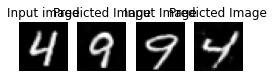

Saving checkpoint for epoch 29 at ./training_checkpoints/CycleGAN/ckpt-29


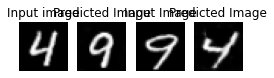

Saving checkpoint for epoch 30 at ./training_checkpoints/CycleGAN/ckpt-30


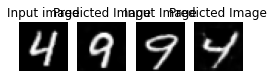

Saving checkpoint for epoch 31 at ./training_checkpoints/CycleGAN/ckpt-31


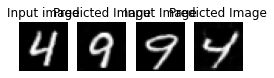

Saving checkpoint for epoch 32 at ./training_checkpoints/CycleGAN/ckpt-32


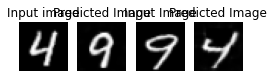

Saving checkpoint for epoch 33 at ./training_checkpoints/CycleGAN/ckpt-33


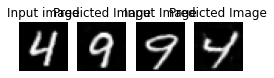

Saving checkpoint for epoch 34 at ./training_checkpoints/CycleGAN/ckpt-34


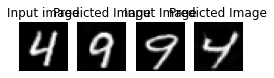

Saving checkpoint for epoch 35 at ./training_checkpoints/CycleGAN/ckpt-35


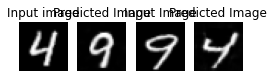

Saving checkpoint for epoch 36 at ./training_checkpoints/CycleGAN/ckpt-36


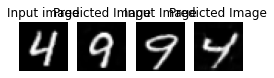

Saving checkpoint for epoch 37 at ./training_checkpoints/CycleGAN/ckpt-37


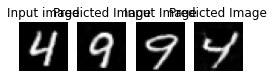

Saving checkpoint for epoch 38 at ./training_checkpoints/CycleGAN/ckpt-38


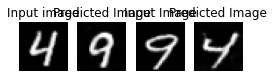

Saving checkpoint for epoch 39 at ./training_checkpoints/CycleGAN/ckpt-39


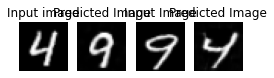

Saving checkpoint for epoch 40 at ./training_checkpoints/CycleGAN/ckpt-40


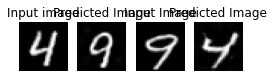

Saving checkpoint for epoch 41 at ./training_checkpoints/CycleGAN/ckpt-41


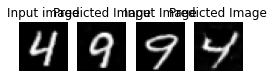

Saving checkpoint for epoch 42 at ./training_checkpoints/CycleGAN/ckpt-42


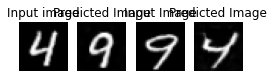

Saving checkpoint for epoch 43 at ./training_checkpoints/CycleGAN/ckpt-43


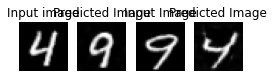

Saving checkpoint for epoch 44 at ./training_checkpoints/CycleGAN/ckpt-44


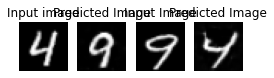

Saving checkpoint for epoch 45 at ./training_checkpoints/CycleGAN/ckpt-45


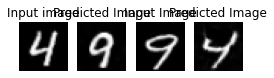

Saving checkpoint for epoch 46 at ./training_checkpoints/CycleGAN/ckpt-46


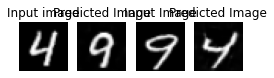

Saving checkpoint for epoch 47 at ./training_checkpoints/CycleGAN/ckpt-47


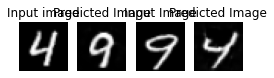

Saving checkpoint for epoch 48 at ./training_checkpoints/CycleGAN/ckpt-48


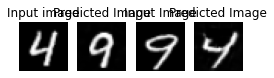

Saving checkpoint for epoch 49 at ./training_checkpoints/CycleGAN/ckpt-49


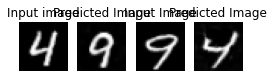

Saving checkpoint for epoch 50 at ./training_checkpoints/CycleGAN/ckpt-50


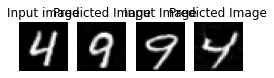

Saving checkpoint for epoch 51 at ./training_checkpoints/CycleGAN/ckpt-51


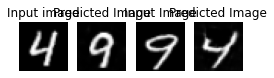

Saving checkpoint for epoch 52 at ./training_checkpoints/CycleGAN/ckpt-52


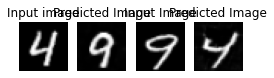

Saving checkpoint for epoch 53 at ./training_checkpoints/CycleGAN/ckpt-53


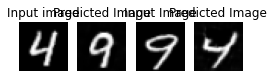

Saving checkpoint for epoch 54 at ./training_checkpoints/CycleGAN/ckpt-54


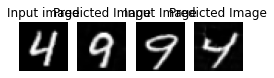

Saving checkpoint for epoch 55 at ./training_checkpoints/CycleGAN/ckpt-55


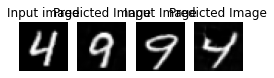

Saving checkpoint for epoch 56 at ./training_checkpoints/CycleGAN/ckpt-56


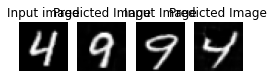

Saving checkpoint for epoch 57 at ./training_checkpoints/CycleGAN/ckpt-57


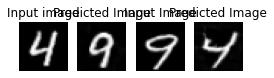

Saving checkpoint for epoch 58 at ./training_checkpoints/CycleGAN/ckpt-58


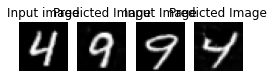

Saving checkpoint for epoch 59 at ./training_checkpoints/CycleGAN/ckpt-59


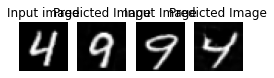

Saving checkpoint for epoch 60 at ./training_checkpoints/CycleGAN/ckpt-60


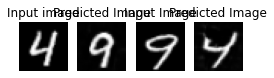

Saving checkpoint for epoch 61 at ./training_checkpoints/CycleGAN/ckpt-61


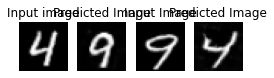

Saving checkpoint for epoch 62 at ./training_checkpoints/CycleGAN/ckpt-62


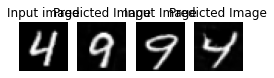

Saving checkpoint for epoch 63 at ./training_checkpoints/CycleGAN/ckpt-63


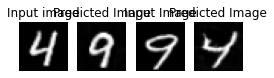

Saving checkpoint for epoch 64 at ./training_checkpoints/CycleGAN/ckpt-64


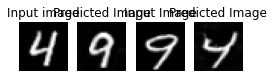

Saving checkpoint for epoch 65 at ./training_checkpoints/CycleGAN/ckpt-65


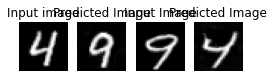

Saving checkpoint for epoch 66 at ./training_checkpoints/CycleGAN/ckpt-66


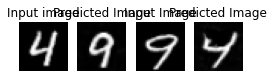

Saving checkpoint for epoch 67 at ./training_checkpoints/CycleGAN/ckpt-67


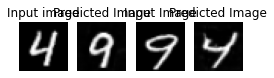

Saving checkpoint for epoch 68 at ./training_checkpoints/CycleGAN/ckpt-68


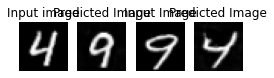

Saving checkpoint for epoch 69 at ./training_checkpoints/CycleGAN/ckpt-69


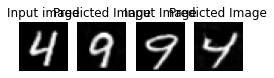

Saving checkpoint for epoch 70 at ./training_checkpoints/CycleGAN/ckpt-70


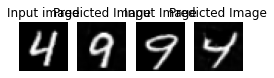

Saving checkpoint for epoch 71 at ./training_checkpoints/CycleGAN/ckpt-71


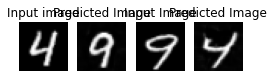

Saving checkpoint for epoch 72 at ./training_checkpoints/CycleGAN/ckpt-72


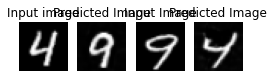

Saving checkpoint for epoch 73 at ./training_checkpoints/CycleGAN/ckpt-73


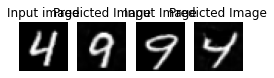

Saving checkpoint for epoch 74 at ./training_checkpoints/CycleGAN/ckpt-74


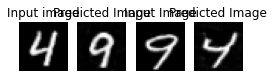

Saving checkpoint for epoch 75 at ./training_checkpoints/CycleGAN/ckpt-75


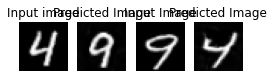

Saving checkpoint for epoch 76 at ./training_checkpoints/CycleGAN/ckpt-76


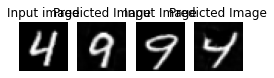

Saving checkpoint for epoch 77 at ./training_checkpoints/CycleGAN/ckpt-77


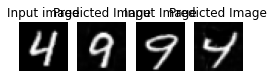

Saving checkpoint for epoch 78 at ./training_checkpoints/CycleGAN/ckpt-78


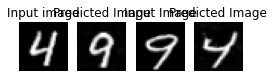

Saving checkpoint for epoch 79 at ./training_checkpoints/CycleGAN/ckpt-79


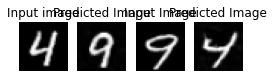

Saving checkpoint for epoch 80 at ./training_checkpoints/CycleGAN/ckpt-80


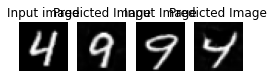

Saving checkpoint for epoch 81 at ./training_checkpoints/CycleGAN/ckpt-81


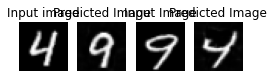

Saving checkpoint for epoch 82 at ./training_checkpoints/CycleGAN/ckpt-82


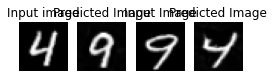

Saving checkpoint for epoch 83 at ./training_checkpoints/CycleGAN/ckpt-83


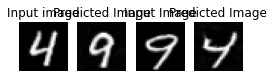

Saving checkpoint for epoch 84 at ./training_checkpoints/CycleGAN/ckpt-84


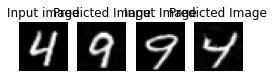

Saving checkpoint for epoch 85 at ./training_checkpoints/CycleGAN/ckpt-85


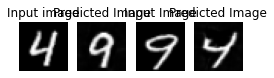

Saving checkpoint for epoch 86 at ./training_checkpoints/CycleGAN/ckpt-86


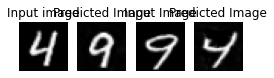

Saving checkpoint for epoch 87 at ./training_checkpoints/CycleGAN/ckpt-87


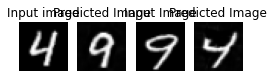

Saving checkpoint for epoch 88 at ./training_checkpoints/CycleGAN/ckpt-88


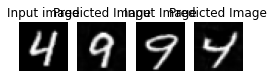

Saving checkpoint for epoch 89 at ./training_checkpoints/CycleGAN/ckpt-89


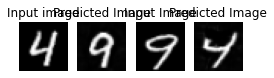

Saving checkpoint for epoch 90 at ./training_checkpoints/CycleGAN/ckpt-90


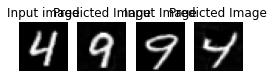

Saving checkpoint for epoch 91 at ./training_checkpoints/CycleGAN/ckpt-91


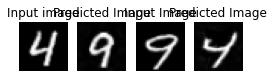

Saving checkpoint for epoch 92 at ./training_checkpoints/CycleGAN/ckpt-92


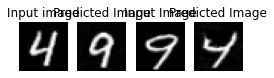

Saving checkpoint for epoch 93 at ./training_checkpoints/CycleGAN/ckpt-93


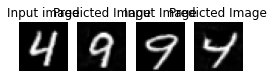

Saving checkpoint for epoch 94 at ./training_checkpoints/CycleGAN/ckpt-94


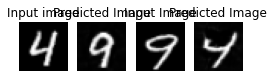

Saving checkpoint for epoch 95 at ./training_checkpoints/CycleGAN/ckpt-95


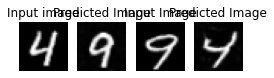

Saving checkpoint for epoch 96 at ./training_checkpoints/CycleGAN/ckpt-96


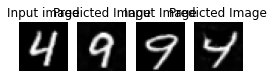

Saving checkpoint for epoch 97 at ./training_checkpoints/CycleGAN/ckpt-97


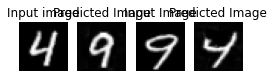

Saving checkpoint for epoch 98 at ./training_checkpoints/CycleGAN/ckpt-98


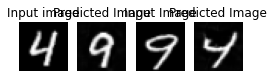

Saving checkpoint for epoch 99 at ./training_checkpoints/CycleGAN/ckpt-99


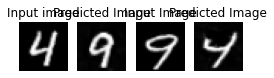

Saving checkpoint for epoch 100 at ./training_checkpoints/CycleGAN/ckpt-100


In [36]:
for epoch in range(1, EPOCHS+1):
    for image_x, image_y in tf.data.Dataset.zip((digit4_data, digit9_data)):
        train_step(image_x, image_y)
    generated_images(generator_g, sample_digit4_data, generator_f, sample_digit9_data)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)
    

### Generating a GIF of Generated Images
After Training let's use our Generators to produce various images from training.
Notice the Quality of results we are getting.

In [37]:
anim_file = './GIFs/CycleGAN/cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./generated_images/CycleGAN/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [38]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to c:\users\jesal\appdata\local\temp\pip-req-build-shua12qe


  ERROR: Error [WinError 2] The system cannot find the file specified while executing command git clone -q https://github.com/tensorflow/docs 'C:\Users\jesal\AppData\Local\Temp\pip-req-build-shua12qe'
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?



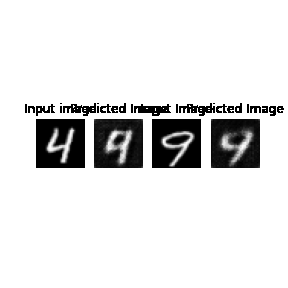

In [39]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)